# **Capitulo 5 – Time Series**

# Setup

Como hicimos en NoteBooks anteriores, vamos a definir los tamaños de fuente por defecto para que las figuras queden más bonitas:

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

Y vamos a crear la carpeta `images/time_series` (si no existe ya), y definir la función `save_fig()` que se utiliza a través de este cuaderno para guardar las figuras:

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "time_series"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# ¿Qué es la estacionalidad? #

Decimos que una serie temporal presenta **estacionalidad** siempre que se produzca un cambio regular y periódico en la media de la serie. Los cambios estacionales suelen seguir el reloj y el calendario: las repeticiones a lo largo de un día, una semana o un año son habituales. La estacionalidad suele estar motivada por los ciclos del mundo natural a lo largo de los días y los años o por las convenciones del comportamiento social en torno a las fechas y las horas.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/ViYbSxS.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Patrones estacionales en cuatro series temporales.
</center></figcaption>
</figure>

Aprenderemos dos tipos de características que modelan la estacionalidad. El primer tipo, indicadores, es mejor para una serie temporal con pocas observaciones, como una temporada semanal de observaciones diarias. El segundo tipo, características de Fourier, es mejor para una serie temporal con muchas observaciones, como una temporada anual de observaciones diarias.

# Gráficos estacionales e indicadores estacionales

Al igual que utilizamos un gráfico de medias móviles para descubrir la tendencia de una serie, podemos utilizar un **gráfico estacional** para descubrir patrones estacionales.

Un gráfico estacional muestra segmentos de la serie temporal trazados contra un periodo común, siendo el periodo la "estación" que se desea observar. La figura muestra un gráfico estacional de las visualizaciones diarias del artículo de Wikipedia sobre *Trigonometría*: las visualizaciones diarias del artículo trazadas sobre un período *semanal* común.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/bd7D4NJ.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Hay un claro patrón estacional semanal en esta serie, más alta entre semana y cayendo hacia el fin de semana.
</center></figcaption>
</figure>

### Indicadores estacionales

**Los indicadores estacionales** son características binarias que representan diferencias estacionales en el nivel de una serie temporal. Los indicadores estacionales son lo que se obtiene si se trata un periodo estacional como una característica categórica y se aplica una codificación de onehotencoder.

Al codificar los días de la semana de una sola vez, obtenemos indicadores estacionales semanales. La creación de indicadores semanales para la serie *Trigonometría* nos dará seis nuevas características "ficticias". (La regresión lineal funciona mejor si se suprime uno de los indicadores; en el cuadro siguiente elegimos el lunes).

| Date       | Tuesday | Wednesday | Thursday | Friday | Saturday | Sunday |
|------------|---------|-----------|----------|--------|----------|--------|
| 2016-01-04 | 0.0     | 0.0       | 0.0      | 0.0    | 0.0      | 0.0    |
| 2016-01-05 | 1.0     | 0.0       | 0.0      | 0.0    | 0.0      | 0.0    |
| 2016-01-06 | 0.0     | 1.0       | 0.0      | 0.0    | 0.0      | 0.0    |
| 2016-01-07 | 0.0     | 0.0       | 1.0      | 0.0    | 0.0      | 0.0    |
| 2016-01-08 | 0.0     | 0.0       | 0.0      | 1.0    | 0.0      | 0.0    |
| 2016-01-09 | 0.0     | 0.0       | 0.0      | 0.0    | 1.0      | 0.0    |
| 2016-01-10 | 0.0     | 0.0       | 0.0      | 0.0    | 0.0      | 1.0    |
| 2016-01-11 | 0.0     | 0.0       | 0.0      | 0.0    | 0.0      | 0.0    |
| ...        | ...     | ...       | ...      | ...    | ...      | ...    |

(puedo eliminar el lunes, ya que si todos son 0 será que es lunes)

Añadir indicadores estacionales a los datos de entrenamiento ayuda a los modelos a distinguir las medias dentro de un periodo estacional:

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/hIlF5j5.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>La regresión lineal ordinaria aprende los valores medios en cada momento de la estación</center></figcaption>
</figure>

Los indicadores actúan como interruptores de encendido y apagado. En cualquier momento, como máximo uno de estos indicadores puede tener un valor de `1` (*On*). La regresión lineal aprende un valor base `2379` para `Mon` y luego ajusta por el valor de cualquier indicador que esté *On* para ese día; el resto son `0` y desaparecen.

# Características de Fourier y el Periodograma

El tipo de característica que discutimos ahora es más adecuado para temporadas largas sobre muchas observaciones donde los indicadores serían poco prácticos. En lugar de crear una característica para cada fecha, las características de Fourier intentan capturar la forma general de la curva estacional con sólo unas pocas características.

Veamos un gráfico de la estación anual en *Trigonometría*. Observe las repeticiones de varias frecuencias: un largo movimiento ascendente y descendente tres veces al año, movimientos semanales cortos 52 veces al año, y quizás otros.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/NJcaEdI.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Estacionalidad anual en la serie <em>Wiki Trigonometría</em></center></figcaption>
</figure>

Son estas frecuencias dentro de una estación las que intentamos captar con las características de Fourier. La idea es incluir en nuestros datos de entrenamiento curvas periódicas que tengan las mismas frecuencias que la estación que intentamos modelizar. Las curvas que utilizamos son las de las funciones trigonométricas seno y coseno.

Las **características de Fourier** son pares de curvas seno y coseno, un par por cada frecuencia potencial de la estación, empezando por la más larga. Los pares de Fourier que modelizan la estacionalidad anual tendrían frecuencias: una vez al año, dos veces al año, tres veces al año, etc.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/bKOjdU7.png" width=600, alt="Una figura superior y otra inferior, cada una mostrando una curva seno y una curva coseno. Las curvas de la figura superior tienen una frecuencia de una vez al año, mientras que las de la figura inferior tienen una frecuencia de dos veces al año.">
<figcaption style="textalign: center; font-style: italic"><center>Los dos primeros pares de Fourier para la estacionalidad anual. <strong>Superior: </strong>Frecuencia de una vez al año. <strong>Inferior: </strong>Frecuencia de dos veces al año</strong></center></figcaption>
</figure>

Si añadimos un conjunto de estas curvas seno / coseno a nuestros datos de entrenamiento, el algoritmo de regresión lineal averiguará los pesos que se ajustarán al componente estacional en la serie objetivo. La figura ilustra cómo la regresión lineal utilizó cuatro pares de Fourier para modelar la estacionalidad anual en la serie *Wiki Trigonometry*.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/mijPhko.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center><strong>Top: </strong>Curvas para cuatro pares de Fourier, una suma de seno y coseno con coeficientes de regresión. Cada curva modela una frecuencia diferente. <strong>Inferior: </strong>La suma de estas curvas aproxima el patrón estacional</center></figcaption>
</figure>

Observe que sólo necesitábamos ocho características (cuatro pares seno / coseno) para obtener una buena estimación de la estacionalidad anual. Compare esto con el método de indicador estacional que habría requerido cientos de características (uno para cada día del año). Al modelizar únicamente el "efecto principal" de la estacionalidad con características de Fourier, normalmente necesitará añadir muchas menos características a sus datos de entrenamiento, lo que se traduce en un menor tiempo de cálculo y un menor riesgo de sobreajuste.

### Elección de características Fourier con el Periodograma

¿Cuántos pares de Fourier deberíamos incluir en nuestro conjunto de características? Podemos responder a esta pregunta con el periodograma. El **periodograma** nos indica la intensidad de las frecuencias en una serie temporal. En concreto, el valor en el eje y del gráfico es `(a ** 2 + b ** 2) / 2`, donde `a` y `b` son los coeficientes del seno y el coseno en esa frecuencia (como en el gráfico de *Componentes de Fourier* anterior).

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/PK6WEe3.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Periodograma para la serie <em>Wiki Trigonometría</em></center></figcaption>
</figure>

De izquierda a derecha, el periodograma cae después de *Trimestre*, cuatro veces al año. Por eso elegimos cuatro pares de Fourier para modelizar la estación anual. La frecuencia *Semanal* la ignoramos ya que se modela mejor con indicadores.

### Cálculo de las características de Fourier (opcional)

Saber cómo se calculan las características de Fourier no es esencial para utilizarlas, pero si ver los detalles aclara las cosas, la celda oculta a continuación ilustra cómo se podría derivar un conjunto de características de Fourier a partir del índice de una serie temporal. (Sin embargo, utilizaremos una función de biblioteca de `statsmodels` para nuestras aplicaciones).

In [3]:
import numpy as np

def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)


# Calcular las características de Fourier hasta el 4º orden (8 nuevas características) para una
# serie y con observaciones diarias y estacionalidad anual:
#
# fourier_features(y, freq=365.25, order=4)

# Ejemplo - Túnel de tráfico #

Continuaremos una vez más con el conjunto de datos *Túnel de Tráfico*.

In [7]:
X

,NumVehicles,day,week,dayofyear,year
Day,,,,,
2003-11-01,103536,5,44,305,2003
2003-11-02,92051,6,44,306,2003
2003-11-03,100795,0,45,307,2003
2003-11-04,102352,1,45,308,2003
2003-11-05,106569,2,45,309,2003
...,...,...,...,...,...
2005-11-12,104646,5,45,316,2005
2005-11-13,94424,6,45,317,2005
2005-11-14,112165,0,46,318,2005


In [4]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

def seasonal_plot(X, y, period, freq, ax=None):
    # Verificar que period y freq sean columnas en X
    assert period in X.columns, f"'{period}' no está en las columnas de X"
    assert freq in X.columns, f"'{freq}' no está en las columnas de X"
    assert y in X.columns, f"'{y}' no está en las columnas de X"

    if ax is None:
        _, ax = plt.subplots()

    palette = sns.color_palette("husl", n_colors=X[period].nunique())

    # Convertir los datos a arrays de NumPy
    x_data = X[freq].values
    y_data = X[y].values
    hue_data = X[period].values

    ax = sns.lineplot(
        x=x_data,
        y=y_data,
        hue=hue_data,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")

    # Ajustar las anotaciones
    unique_periods = np.unique(hue_data)
    for line, name in zip(ax.lines, unique_periods):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )

    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


data_dir = Path("data")
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period("D")

Echemos un vistazo a las parcelas estacionales a lo largo de una semana y a lo largo de un año.

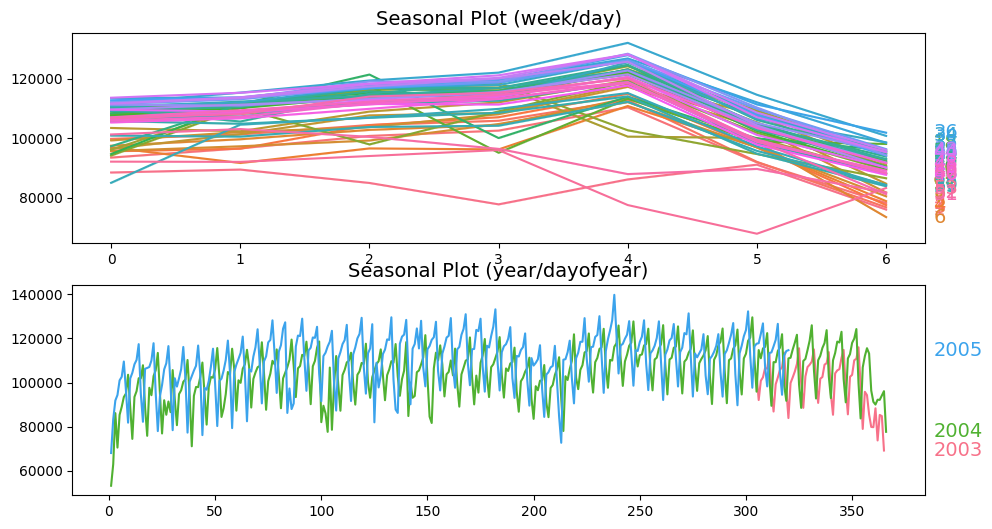

In [6]:
X = tunnel.copy()

º# days within a week
X["day"] = X.index.dayofweek 
X["week"] = X.index.week 

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="NumVehicles", period="year", freq="dayofyear", ax=ax1);

Ahora veamos el periodograma:

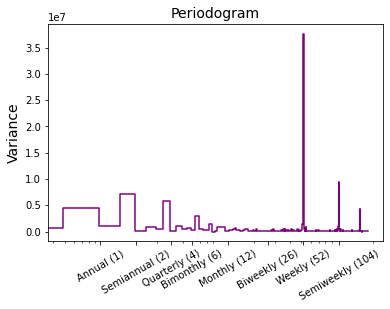

In [7]:
plot_periodogram(tunnel.NumVehicles);

El periodograma coincide con los gráficos estacionales anteriores: una fuerte temporada semanal y una temporada anual más débil. La temporada semanal la modelizaremos con indicadores y la anual, con características de Fourier. De derecha a izquierda, el periodograma cae entre *Bimestral (6)* y *Mensual (12)*, por lo que utilizaremos 10 pares de Fourier.

Crearemos nuestras características estacionales utilizando `DeterministicProcess`, para crear características de tendencia. Para utilizar dos periodos estacionales (semanal y anual), necesitaremos instanciar uno de ellos como "término adicional":

In [8]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 pares sin/cos para la estacionalidad "Anual"

dp = DeterministicProcess(
    index=tunnel.index,
    constant=True,               # característica ficticia para el sesgo (intersección y)
    order=1,                     # tendencia (orden 1 significa lineal)
    seasonal=True,               # estacionalidad semanal (indicadores)
    additional_terms=[fourier],  # estacionalidad anual (fourier)
    drop=True,                   # eliminar términos para evitar colinealidad
)

X = dp.in_sample()  # create features for dates in tunnel.index

Una vez creado nuestro conjunto de características, estamos listos para ajustar el modelo y hacer predicciones. Añadiremos una predicción a 90 días para ver cómo nuestro modelo extrapola más allá de los datos de entrenamiento. El código aquí es el mismo que en NoteBooks anteriores.

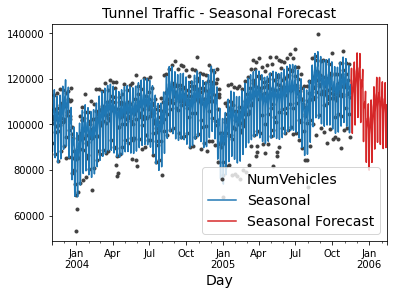

In [9]:
y = tunnel["NumVehicles"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90) #predicción 
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

---

Aún podemos hacer más con las series temporales para mejorar nuestras previsiones. En el próximo NoteBook, aprenderemos a utilizar las propias series temporales como características. El uso de series temporales como entradas de una previsión nos permite modelar otro componente que se encuentra a menudo en las series: *los ciclos*.
